# Representative Ordering: PCA + KMeans Visualization

This notebook projects MegaMedical image embeddings to 2D with PCA and colors points by KMeans cluster labels.

In [101]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

repo_root = Path("/data/ddmg/mvseg-ordering")
for path in [repo_root, repo_root / "UniverSeg", repo_root / "MultiverSeg"]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

from experiments.dataset.mega_medical_dataset import MegaMedicalDataset
from experiments.encoders.multiverseg_encoder import MultiverSegEncoder
from experiments.encoders.clip import CLIPEncoder
from experiments.encoders.vit import ViTEncoder
from experiments.encoders.dinov2 import DinoV2Encoder
from experiments.encoders.medsam import MedSAMEncoder


## Load MegaMedical embeddings

Set a target index and encoder type; adjust `dataset_size` for speed.

In [102]:
# Choose a MegaMedical target index
dataset_target = 12
dataset_split = "train"
dataset_size = None  # set None to use full dataset
encoder_type = "medsam"  # multiverseg | clip | vit | dinov2 | medsam
seed = 23
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ds = MegaMedicalDataset(
    dataset_target=dataset_target,
    split=dataset_split,
    dataset_size=dataset_size,
)
if encoder_type == "multiverseg":
    encoder = MultiverSegEncoder(pooling="gap_gmp")
elif encoder_type == "clip":
    encoder = CLIPEncoder(model_name="ViT-B-32", pretrained="openai")
elif encoder_type == "vit":
    encoder = ViTEncoder(model_name="vit_b_16", pretrained=True)
elif encoder_type == "dinov2":
    encoder = DinoV2Encoder(model_name="facebook/dinov2-base")
elif encoder_type == "medsam":
    encoder = MedSAMEncoder(model_type="vit_b")
else:
    raise ValueError(f"Unknown encoder_type: {encoder_type}")
encoder = encoder.to(device).eval()
print(f"Loaded dataset with {len(ds)} samples.")

# Describe dataset target and encoder
dataset_target_name = None
if hasattr(ds, "_data") and hasattr(ds._data, "task_df"):
    try:
        row = ds._data.task_df.loc[dataset_target]
        dataset_target_name = f"{row.get('dataset', '')}/{row.get('task', '')}/label{row.get('label', '')}/{row.get('slicing', '')}"
    except Exception:
        dataset_target_name = None
print(f"dataset_target={dataset_target} name={dataset_target_name}")
print(f"encoder_type={encoder_type}")


No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248


/data/ddmg/mvseg-ordering/experiments/encoders/medsam.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(self.checkpoint_path, map_location=torch.device

Loaded dataset with 60 samples.
dataset_target=12 name=None
encoder_type=medsam


In [ ]:
# Compute embeddings Z and keep the original images for visualization
embeddings = []
images = []

with torch.no_grad():
    for i in range(len(ds)):
        img, _ = ds[i]
        img = img.to(device)
        emb = encoder(img).detach().cpu().numpy()
        embeddings.append(emb.squeeze(0))
        images.append(img.detach().cpu().numpy())

Z = np.stack(embeddings, axis=0)
images = np.stack(images, axis=0)  # (N, C, H, W)
print("Z shape:", Z.shape)
print("images shape:", images.shape)


## Simulated subset (size 10, seed 23)

This matches the Plan B sampling style: random subset without replacement within the subset.
We generate multiple subsets and take the first one.

In [ ]:
subset_size = 10
subset_count = 10
if subset_size > Z.shape[0]:
    raise ValueError("subset_size cannot exceed the number of embeddings.")
rng = np.random.default_rng(seed)
subset_indices = [rng.choice(Z.shape[0], size=subset_size, replace=False).tolist()
                 for _ in range(subset_count)]
first_subset = subset_indices[0]
Z_subset = Z[first_subset]
images_subset = images[first_subset]
print("first_subset indices:", first_subset)


first_subset indices: [15, 3, 4, 0, 1, 11, 6, 7, 14, 8]


## Visualize original images (subset)

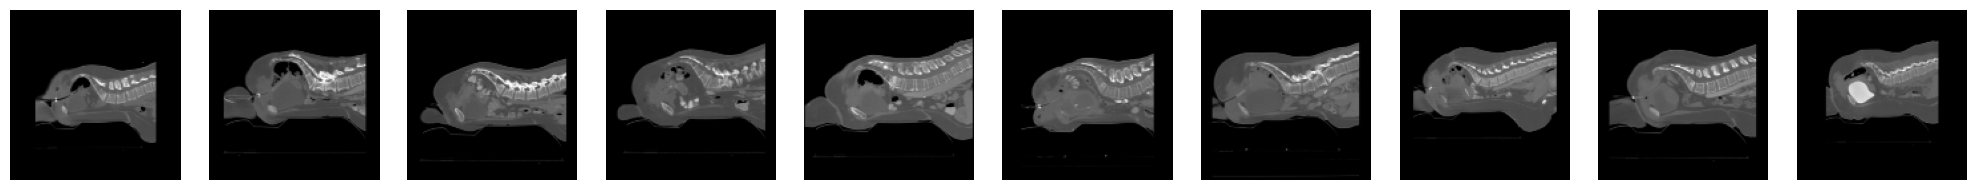

In [ ]:
n_show = min(10, images_subset.shape[0])
fig, axes = plt.subplots(1, n_show, figsize=(2 * n_show, 2))
if n_show == 1:
    axes = [axes]
for i in range(n_show):
    img = images_subset[i]
    if img.ndim == 3:  # C, H, W -> H, W (if single-channel)
        if img.shape[0] == 1:
            img = img[0]
        else:
            img = np.transpose(img, (1, 2, 0))
    axes[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## PCA + KMeans + silhouette

silhouette_score: 0.0149


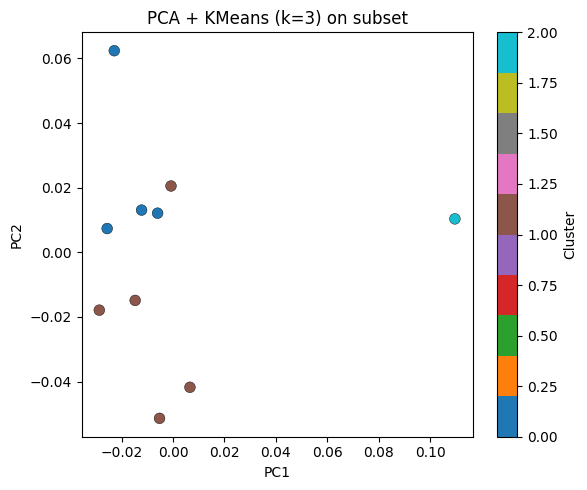

In [ ]:
k = 3
use_subset = True  # set False to use all embeddings
Z_use = Z_subset if use_subset else Z

pca = PCA(n_components=2, random_state=seed)
Z2 = pca.fit_transform(Z_use)

kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto")
labels = kmeans.fit_predict(Z_use)

sil = np.nan
if len(np.unique(labels)) > 1 and Z_use.shape[0] > k:
    sil = silhouette_score(Z_use, labels)
print(f"silhouette_score: {sil:.4f}")

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z2[:, 0],
    Z2[:, 1],
    c=labels,
    cmap="tab10",
    s=60,
    edgecolors="k",
    linewidths=0.3,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
title_scope = "subset" if use_subset else "full"
plt.title(f"PCA + KMeans (k={k}) on {title_scope} {encoder_type} {dataset_target}")
plt.colorbar(sc, label="Cluster")
plt.tight_layout()
plt.show()


## Visualize images by cluster

This shows a grid of images for each cluster label.

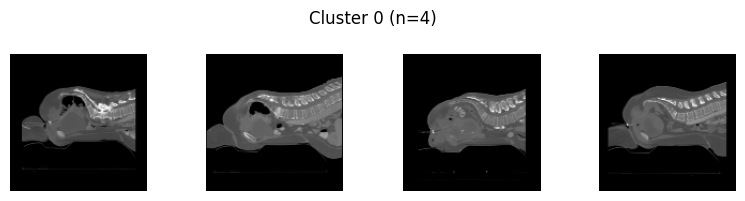

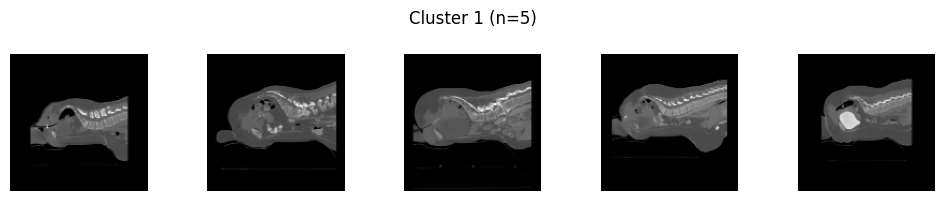

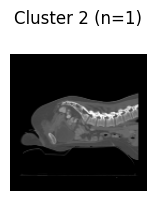

In [ ]:
# Show images for each cluster
# Assumes images_subset (subset) or images (full) are aligned with Z_use.

images_use = images_subset if use_subset else images

if images_use is None:
    raise ValueError('images not found; make sure images were loaded alongside Z.')

max_per_cluster = 10
for c in range(k):
    idxs = np.where(labels == c)[0]
    if idxs.size == 0:
        continue
    idxs = idxs[:max_per_cluster]
    n_show = idxs.size
    fig, axes = plt.subplots(1, n_show, figsize=(2 * n_show, 2))
    if n_show == 1:
        axes = [axes]
    for j, idx in enumerate(idxs):
        img = images_use[idx]
        if img.ndim == 3:  # C, H, W -> H, W (if single-channel)
            if img.shape[0] == 1:
                img = img[0]
            else:
                img = np.transpose(img, (1, 2, 0))
        axes[j].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[j].axis('off')
    fig.suptitle(f'Cluster {c} (n={idxs.size})')
    plt.tight_layout()
    plt.show()
